<a href="https://colab.research.google.com/github/100rab-S/Fun-With-MNIST/blob/main/MNIST-4/V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content/drive/MyDrive/Fun With MNIST/MNIST-4(Object Detection)

/content/drive/MyDrive/Fun With MNIST/MNIST-4(Object Detection)


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Input, Lambda, Flatten
from tensorflow.image import draw_bounding_boxes
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model

import logging  
import os

In [3]:
# IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
# if IS_COLAB_BACKEND:
#   from google.colab import auth
#   # Authenticates the Colab machine and also the TPU using your
#   # credentials so that they can access your private GCS buckets.
#   auth.authenticate_user()

In [3]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
# print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.56.237.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.56.237.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


In [4]:
batch_size = 64
BATCH_SIZE = batch_size * strategy.num_replicas_in_sync # Gobal batch size.
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

X = np.concatenate((x_train, x_test), axis = 0)/255. #contatenating both train and test dataset to create one large dataset.
Y = np.concatenate((y_train, y_test))
print('Shape of the dataset after concatinating:')
print(X.shape, Y.shape)

Shape of the dataset after concatinating:
(70000, 28, 28) (70000,)


In [10]:
def create_dataset(X, Y, dataset_size):
    '''
    Function to create dataset for object detection by horizontally stacking two images.
    Parameters:
            dataset_size = size of the dataset to be created
    Returns : New dataset with two classes in one image and size of the returned dataset will not match with dataset_size variable, 
                since we drop few images.
    '''

    count = 0
    w, h = 28, 28
    desired_output = 100
    IMGS = np.zeros((dataset_size,100, 100, 1))
    BOXES = np.zeros((dataset_size, 20))

    no_of_removes = 0
    while(True):
        indices = np.random.randint(0, 70000, size = 2) #randomly selecting two indices for stacking.
        ans1, ans2 = Y[indices[0]], Y[indices[1]]
        if ans1 == ans2:  # check if both the images have same target, if yes then skip that example and donot add it to the dataset. Although this
                            # should not effect the model's performance but still for sanity check.
          no_of_removes +=1

        else:
            image1 = X[indices[0]]
            image2 = X[indices[1]]
            canvas = np.zeros((desired_output, desired_output))

            while(True):
                rand_width1, rand_width2 = np.random.randint(28, high = 101, size = 2)  # x_max
                rand_height1, rand_height2 = np.random.randint(72, size = 2)        # y_min

                if (abs(rand_width1 - rand_width2)>=30 or abs(rand_height1 - rand_height2) >= 30):
                    break

            canvas[rand_height1 : rand_height1+28, rand_width1-28 : rand_width1] = image1
            canvas[rand_height2 : rand_height2+28, rand_width2-28 : rand_width2] = image2
            canvas = np.expand_dims(canvas, axis = -1)

            div = float(desired_output)                         # to normalize the values
            
            boxes = np.zeros((10, 2))
            boxes[ans1] = rand_width1/div, rand_height1/div
            boxes[ans2] = rand_width2/div, rand_height2/div

            boxes = boxes.flatten()

            IMGS[count] = canvas
            BOXES[count] = boxes

            count +=1
        if count >= dataset_size:
            break

    print(f'No of examples removed from dataset: {no_of_removes}')
    return IMGS, BOXES

In [8]:
def display_bound_boxes(images, boxes, labels):
    '''
    Displays images with bounding boxes. Accepts 4D images, 3D boxes, 2D labels
    '''
    images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(images)).numpy()
    color = np.array([[1.0, 0.0, 0.0], [2.0, 0.0, 0.0]])

    images = draw_bounding_boxes(images, boxes, colors=color)

    
    nrows = np.ceil(len(images)/10).astype(int)
    fig, axes = plt.subplots(nrows, 10, figsize = (20, 3*nrows), sharex = True, sharey=True)
    for ax, image, label in zip(axes.ravel(), images, labels):
        label = str(label[0]) + ', ' + str(label[1])

        logger = logging.getLogger()
        old_level = logger.level
        logger.setLevel(100)


        ax.imshow(image, cmap = 'gray')
        ax.set_title(label)

        logger.setLevel(old_level)

In [13]:
valid_dataset = tf.data.Dataset.from_tensor_slices(create_dataset(X, Y, 5000))
valid_dataset = valid_dataset.shuffle(102).batch(BATCH_SIZE, drop_remainder = True).prefetch(-1)

No of examples removed from dataset: 536


In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(create_dataset(X, Y, 25000))
train_dataset = train_dataset.shuffle(102).batch(BATCH_SIZE, drop_remainder = True).prefetch(-1)

No of examples removed from dataset: 2719


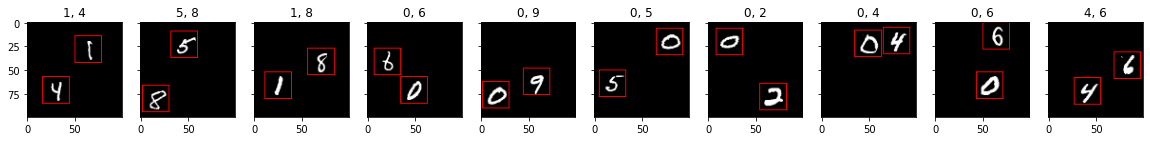

In [65]:
# Display random digits from both training and validation dataset with predictions and boxes

dataset = train_dataset
batches = 2
batch_size = 5
y = []
train_images = []
train_boxes = []
train_labels = []
div = 100
for n, ele in enumerate(dataset.unbatch().batch(batch_size).shuffle(5).as_numpy_iterator()):
    if n>=batches:
        break
    train_images.append(ele[0])
    y.append(ele[1])
train_images = np.array(train_images).reshape((batches*batch_size, 100, 100, 1))
for batch in range(batches):
    batch_boxes = y[batch]
    batch_boxes_list = []
    for each_10_box in batch_boxes:
        each_10_box = each_10_box.reshape((10, 2))

        for n, each_box in enumerate(each_10_box):
            if (each_box[0] > 0.09 and each_box[1] >= 0.0):
                train_labels.append(n)
                box = [each_box[1], (each_box[0]*100 - 28)/div, (each_box[1]*100 + 28)/div, each_box[0]]
                batch_boxes_list.append(box)

    train_boxes.append(batch_boxes_list)
train_boxes = np.array(train_boxes).reshape(batches*batch_size, 2, 4)
train_labels = np.array(train_labels).reshape(batches*batch_size, 2)

display_bound_boxes(train_images, train_boxes, train_labels)

In [17]:
# define model

def feature_extractor(inputs):
    x = Conv2D(32, 3, padding = 'same', activation='relu')(inputs)
    x = MaxPooling2D()(x)

    x = Conv2D(32, 3, activation='relu', padding = 'same')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)

    return x

def dense_part(inputs):
    x = Flatten()(inputs)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)

    return x

def regressor_output(inputs):
    # x = Dense(128, activation = 'relu')(inputs)
    x = Dense(64, activation = 'relu')(inputs)
    # x = Dropout(0.2)(x)
    # x = Dense(32, activation = 'relu')(x)
    x = Dense(32, activation = 'relu')(x)
    output = Dense(20, name = 'Regressor')(x)

    return output

# @tf.function
def myModel():
    input = Input(shape = (100, 100, 1))

    extractor_ouptput = feature_extractor(input)
    dense_output = dense_part(extractor_ouptput)
    # output1 = classifier_output(dense_output)
    output2 = regressor_output(dense_output)

    model = Model(input, output2)

    return model


In [50]:
with strategy.scope():
    model = myModel()
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss = 'mse', metrics = ['accuracy'])

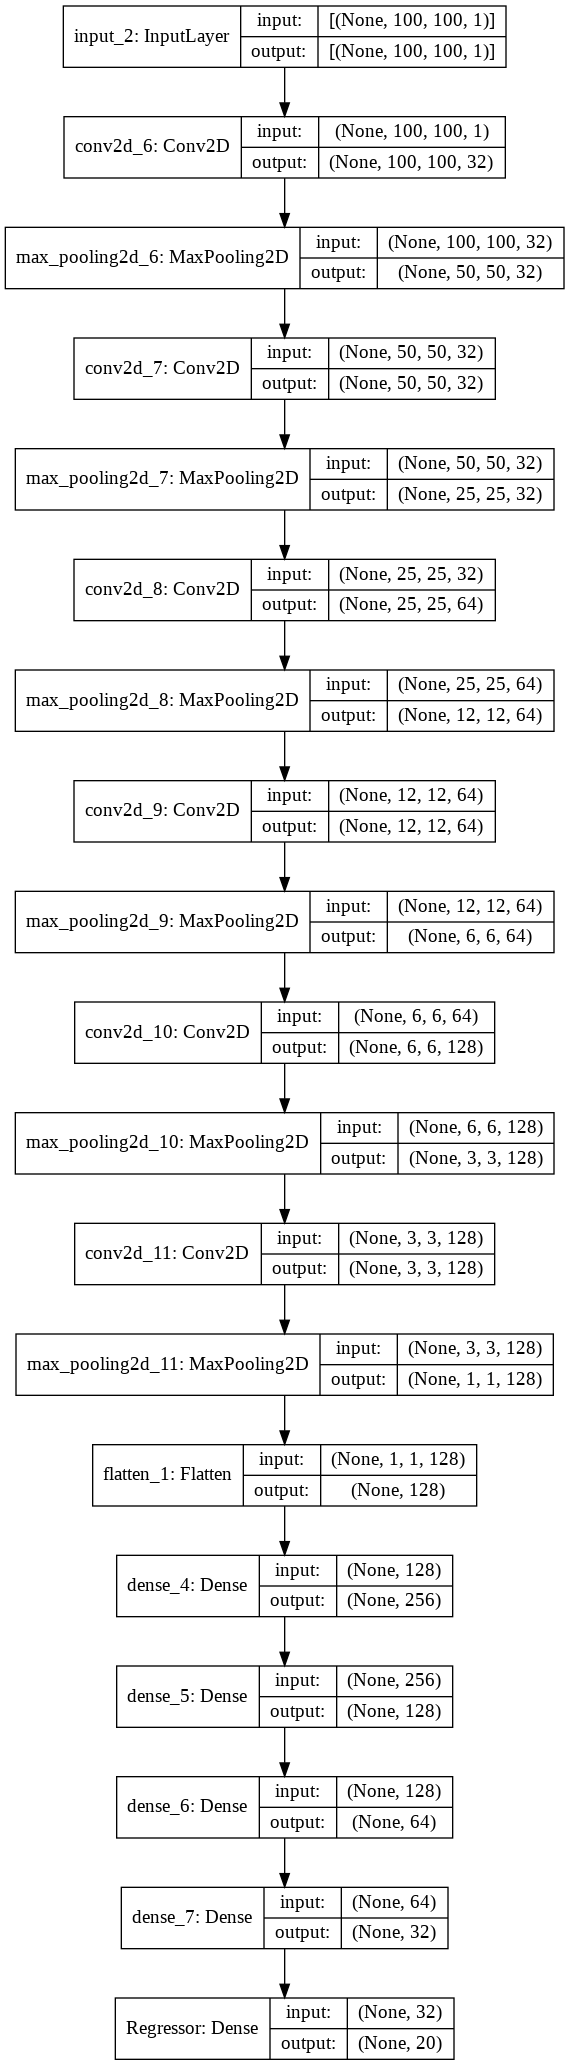

In [66]:
plot_model(model, show_shapes=True)

In [57]:
def print_evaluate():
    train_acc = hist.history['accuracy']
    train_loss = hist.history['loss']

    valid_acc = hist.history['val_accuracy']
    valid_loss = hist.history['val_loss']

    epochs = range(len(train_acc))

    plt.plot(epochs, train_acc, 'r', label = 'Train Accuracy',)
    plt.plot(epochs, valid_acc, 'b', label = 'Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.show()

    plt.plot(epochs, train_loss, 'r', label = 'Train Loss')
    plt.plot(epochs, valid_loss, 'b', label = 'Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.show()

In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta = 0.01, patience=80, verbose = 1, restore_best_weights=True)

In [51]:
epochs = 500
# steps_per_epoch = 30000//BATCH_SIZE
# val_steps = 5000//BATCH_SIZE

hist = model.fit(train_dataset, epochs = epochs, validation_data= valid_dataset)

Epoch 1/500
48/48 [==============================] - 9s 75ms/step - loss: 0.0582 - accuracy: 0.0926 - val_loss: 0.0524 - val_accuracy: 0.0964
Epoch 2/500
48/48 [==============================] - 3s 53ms/step - loss: 0.0520 - accuracy: 0.1220 - val_loss: 0.0505 - val_accuracy: 0.1756
Epoch 3/500
48/48 [==============================] - 3s 57ms/step - loss: 0.0483 - accuracy: 0.2003 - val_loss: 0.0432 - val_accuracy: 0.2886
Epoch 4/500
48/48 [==============================] - 3s 53ms/step - loss: 0.0418 - accuracy: 0.3097 - val_loss: 0.0378 - val_accuracy: 0.3685
Epoch 5/500
48/48 [==============================] - 3s 53ms/step - loss: 0.0365 - accuracy: 0.3953 - val_loss: 0.0321 - val_accuracy: 0.4991
Epoch 6/500
48/48 [==============================] - 3s 52ms/step - loss: 0.0304 - accuracy: 0.5136 - val_loss: 0.0246 - val_accuracy: 0.5970
Epoch 7/500
48/48 [==============================] - 3s 57ms/step - loss: 0.0223 - accuracy: 0.6065 - val_loss: 0.0170 - val_accuracy: 0.6810
Epoch 

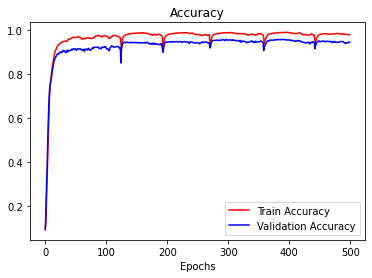

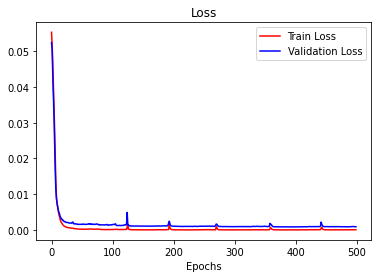

In [58]:
print_evaluate()

In [59]:
output = model.evaluate(valid_dataset)
# print(len(output))

for val in output:
    print(val)

9/9 [==============================] - 1s 22ms/step - loss: 9.0798e-04 - accuracy: 0.9444
0.0009079767041839659
0.944444477558136


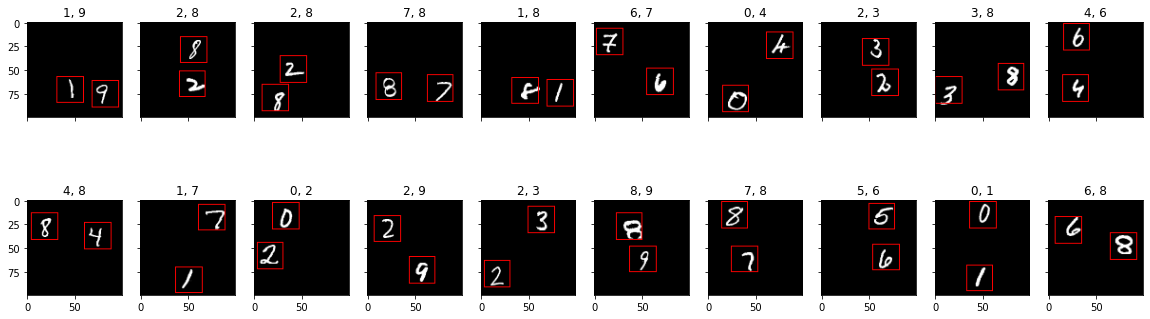

In [67]:
# Display predictions from validation dataset along with bounding boxes

batches = 2
batch_size = 10
pred = []
test_images = []
test_boxes = []
test_labels = []

for n, ex in enumerate(valid_dataset.unbatch().batch(batch_size).shuffle(100).as_numpy_iterator()):
    if n>=batches:
        break
    pred.append(model.predict([[ex[0]]]))
    test_images.append(ex[0])
test_images = np.array(test_images).reshape((batches*batch_size, 100, 100, 1))

for batch in range(batches):
    # test_labels.append(pred[batch][0])
    batch_boxes = pred[batch]
    batch_boxes_list = []
    for each_10_box in batch_boxes:
        each_10_box = each_10_box.reshape((10, 2))

        for n, each_box in enumerate(each_10_box):
            # print('each box\n', each_box)
            if (each_box[0] > 0.15 and each_box[1] >= 0.0):
                box = [each_box[1], (each_box[0]*100 - 28)/div, (each_box[1]*100 + 28)/div, each_box[0]]

                batch_boxes_list.append(box)
                test_labels.append(n)

    test_boxes.append(batch_boxes_list)
test_boxes = np.array(test_boxes).reshape(batches*batch_size,2, 4)
test_labels = np.array(test_labels).reshape(batches*batch_size, 2)
# Prediction on validation dataset

display_bound_boxes(test_images, test_boxes, test_labels)


In [46]:
model.save('mnist-4-7.h5')